# Sirius B Preprocessing

Adapted from ["NIRC Preprocessing Streamlined"](https://github.com/vortex-exoplanet/NIRC2_Preprocessing/blob/master/NIRC2_Preprocessing_%20streamlined.ipynb)

## Import <a id='import'></a>

In [3]:
import sys
import os

import numpy as np
import vip_hci as vip
from hciplot import plot_frames
from os.path import join
import matplotlib.pyplot as plt
import tqdm.auto as tqdm

sys.path.append("../src")

import paths
from NIRC2_Preprocessing import *

plt.style.use(["fivethirtyeight", "seaborn-notebook"])

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Open a ds9 window

In [10]:
ds9 = vip.Ds9Window()

---

## Calibration

Build the master flat and preprocess the sci and sky images: Let's run !

In [7]:
# File list
filelist_flat = listing(paths.flat, selection=False, ext="fits")
filelist_sci = listing(paths.sci, selection=False, ext="fits")
filelist_sky = listing(paths.sky, selection=False, ext="fits")

# Generate master flat
master_flat, bad_pixel_map = masterFlat(
    filelist_flat,
    save=True,
    bpm=True,
    verbose=True,
    filtering=5,
    path_output=paths.output,
    filename="master_flat",
    full_output=True,
)

# Generate master sky
master_sky, _ = master(
    listing(join(paths.output, "sky_flatted")),
    norm=False,
    save=True,
    filename="master_sky",
    path_output=join(paths.output, "calibration"),
    verbose=True,
    filtering=None,
)

# Flat correct science images
sci_preprocessed = applyFlat(
    filelist_sci, master_flat, save=True, path_output=paths.output, verbose=True
)
# Flat correct sky images
sky_preprocessed = applyFlat(
    filelist_sky, master_flat, save=True, path_output=paths.output, verbose=True
)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2020-04-27 11:41:55
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
BUILDING THE MASTER IMAGE

Save = True
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2020-04-27 11:41:55
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――

Done replacing bad pixels using the median of the neighbors
Running time:  0:00:00.085827
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
filtering = 5
Fits file successfully overwritten

-------------------------------------------------------------------
Master image successfully created
Running time:  0:00:00.375089
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2020-04-27 11:41:55
――――――――――――――――

Display the sci and sky preprocessed images. We see a diffraction spike in the master sky and in `n0214`. This corresponds to light from Sirius A diffracting off the telescope (wow!). In the calibrated frame of `n0112` you can see, also, the autocorrelation of the NIRC2 detector causing the horizontal "double-V" pattern.

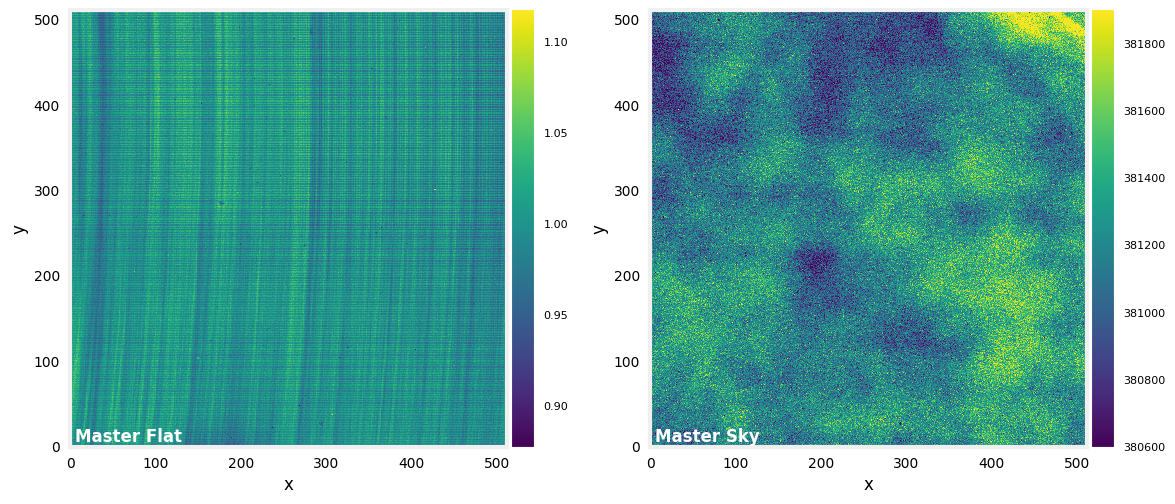

In [19]:
plot_frames(
    (master_flat, master_sky),
    label=("Master Flat", "Master Sky"),
    vmin=(None, 3.806e5),
    vmax=(None, 3.819e5),
    horsp=0.25,
)

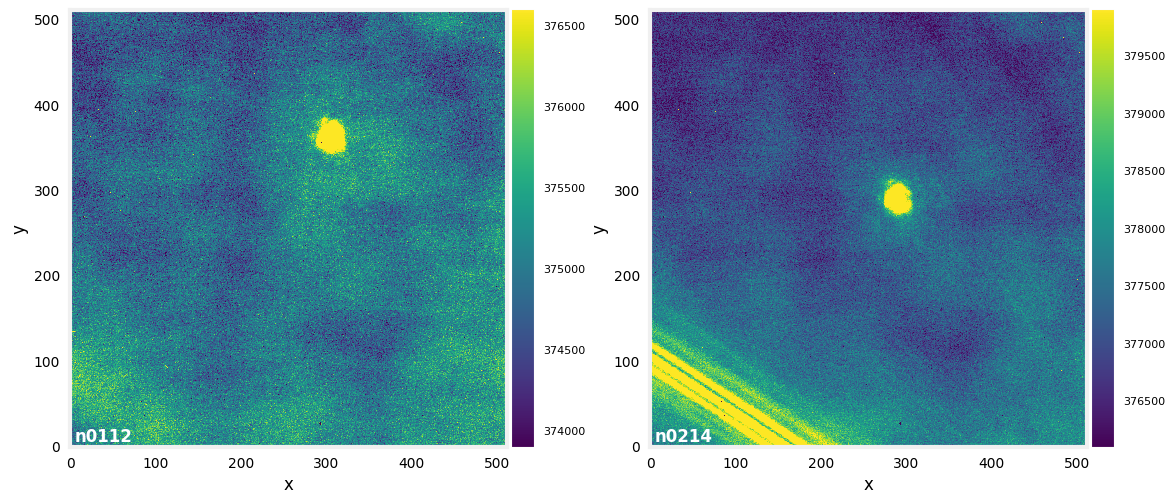

In [22]:
plot_frames(
    (sci_preprocessed[39], sci_preprocessed[151]),
    label=("n0112", "n0214"),
    vmin=(3.739e5, 3.761e5),
    vmax=(3.766e5, 3.799e5),
    horsp=0.25,
)

In [12]:
ds9.display(sci_preprocessed, master_sky, master_flat)

## Sky Subtraction

The master sky did not work well for sky-subtraction, partially due to the diffraction spike in the top-right as well as the fact that the sky images were taken at the end of over 3 hours of observing, therefore the sky may have substantially changed over that time and one static image would not be a good estimator. 

Here I subtract a median-filtered version of each frame as a form of background subtraction. A box size of ~30 seemed to work well without over-subtracting or under-subtracting, and the runtime of around 10 minutes is acceptable.

In [23]:
sci_skysubbed = vip.var.cube_filter_highpass(
    sci_preprocessed, mode="median-subt", median_size=32
)

0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:09:35


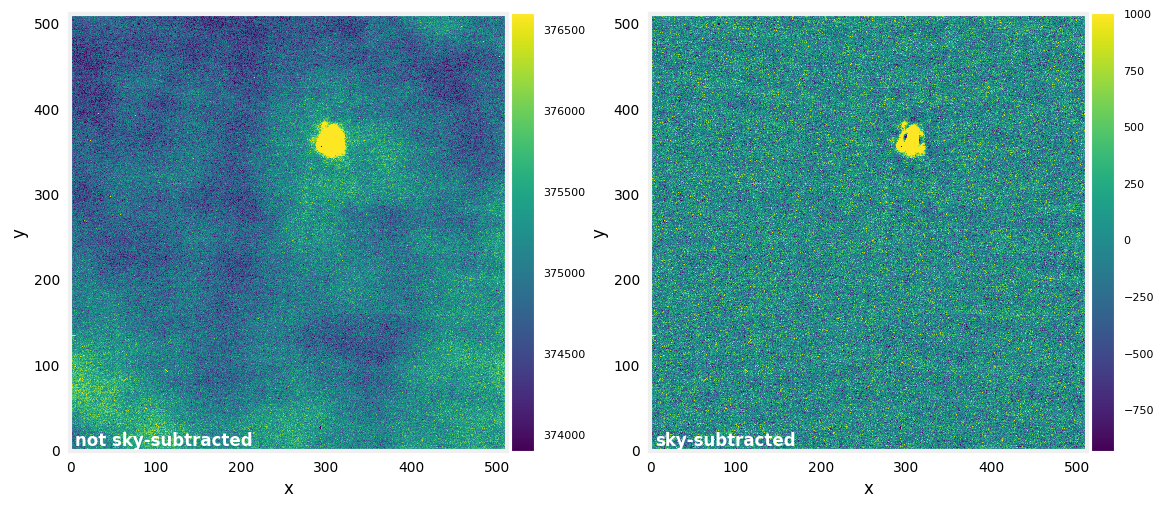

In [26]:
plot_frames(
    (sci_preprocessed[39], sci_skysubbed[39]),
    label=("not sky-subtracted", "sky-subtracted"),
    vmin=(3.739e5, -9.3e2),
    vmax=(3.766e5, 1e3),
    horsp=0.25,
)

In [25]:
ds9.display(sci_skysubbed)

## Registration and Cropping

### Bad Frame Removal

For whatever reason, the 88th frame is just nothing, so drop it

In [28]:
sci_skysubbed_ = np.delete(sci_skysubbed, 87, 0)

In [172]:
ds9.display(sci_skysubbed_)

### Registration

I noticed registration would often fail without doing bad-pixel removal. Here I use simple sigma-clipping from vip to remove the bad-pixels

In [29]:
bp_rm = vip.preproc.cube_fix_badpix_isolated(sci_skysubbed_)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2020-04-27 12:10:58
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
processing frames
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:19
/nDone replacing bad pixels using the median of the neighbors
Running time:  0:00:54.585792
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


Now I'm going to use some of the registration tools from VIP to center my frames. First, this will find the centroid of the first frame and shift it. Then, using the DFT upsampling method we can find the translation for the rest of the frames to the first (thanks Fourier!). This worked pretty well for even these relatively large offsets.

The FWHM here is stolen from the ADI analysis (it's time traveling), but is about what we expect from using the narrow platescale mode of NIRC2.

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2020-04-27 12:15:38
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Shift for first frame X,Y=(-32.402, -29.972)
The rest of the frames will be shifted by cross-correlation wrt the 1st
frames
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07
Running time:  0:00:08.313688
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


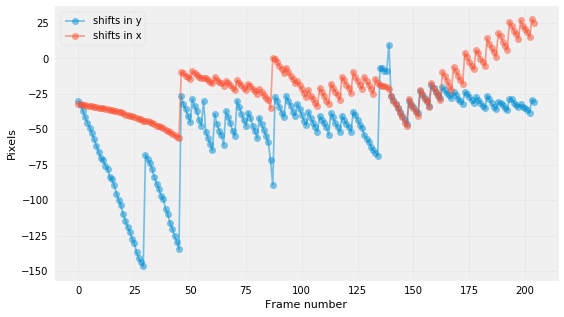

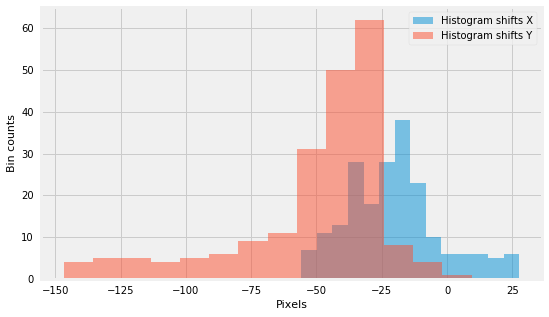

In [30]:
centered_dft = vip.preproc.cube_recenter_dft_upsampling(
    bp_rm, center_fr1=(283, 288), subi_size=50, fwhm=8.41
)

In [188]:
ds9.display(centered_dft)

after that, I switch to using the 2D fit registration method (using Gaussian model), which claims to have good sub-pixel accuracy. The histograms show any corrections made here are quite minor, although it is fast enough that chaining it with the DFT registration is not an issue.

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2020-04-27 12:17:21
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
`subi_size` is odd (while frame size is even)
Setting `subi_size` to 52 pixels
2d Gauss-fitting
frames
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
Shifting
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
Running time:  0:00:02.985264
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


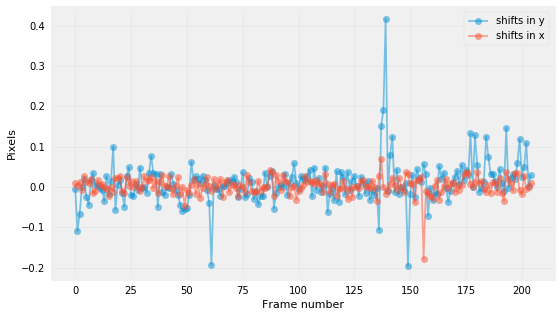

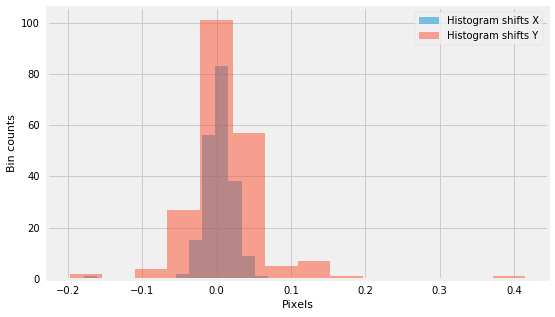

In [31]:
centered = vip.preproc.cube_recenter_2dfit(centered_dft, subi_size=51)

In [190]:
ds9.display(centered)

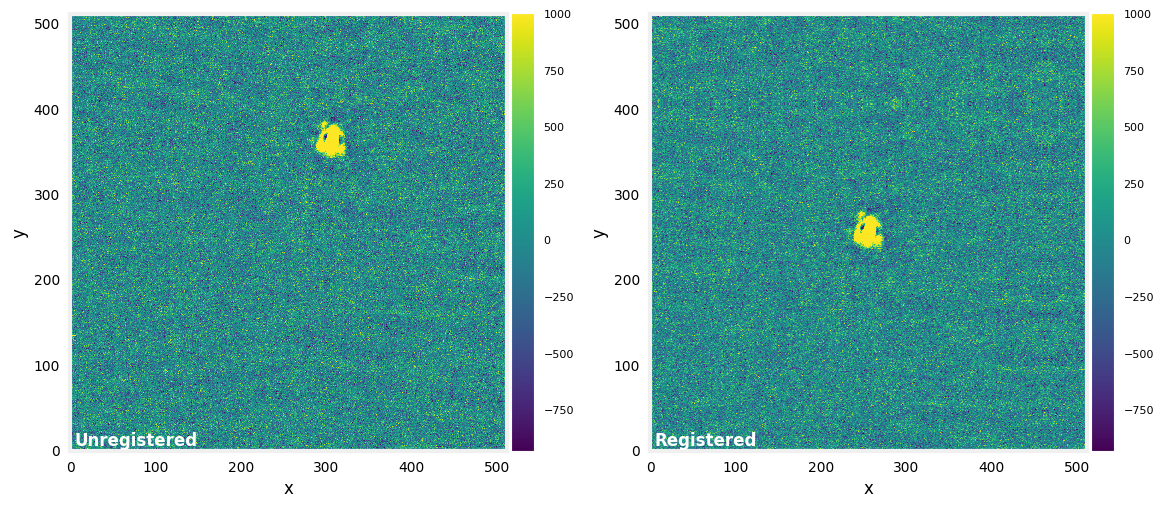

In [33]:
plot_frames(
    (bp_rm[39], centered[39]),
    label=("Unregistered", "Registered"),
    vmin=-9.3e2,
    vmax=1e3,
    horsp=0.25,
)

## Spike Correction

<div class="alert alert-warning">
<b>Warning:</b>
This section was not fully worked out, since we didn't determine it worth the hassle at the time of analysis given the ~130 frames remaining if we just ignore the images with spikes. Please consider this section exploratory and not part of the official reduction.    
</div>

Let's take a look at the 2D Fourier transforms of an image with a spike and one without-

In [281]:
all_frames = np.delete(sci_sky_subtracted_, 87, 0)[[0, 82, 88, 124]]
rffts = np.array([np.abs(np.fft.fftshift(np.fft.rfft2(frame))) for frame in all_frames])

In [335]:
ds9.display(rffts)

In [297]:
# from my NRAO summer project code
def radial_profile(image, center=None):
    """
	Gets the radial profile of the FFT or, equivalently, the PSD
	
	Parameters
	----------
	image : 2D Array
		The two dimensional image data array.
	center : 2 tuple, optional
		A tuple of length 2 that defines the central pixel (the default is None, 
		which lets the center be [image.shape() / 2])
	
	Returns
	-------
	ndarray
		The radial profile or PSD
	"""

    y, x = np.indices((image.shape))

    if center is None:
        center = np.array([np.max(x) / 2.0, np.max(y) / 2.0])

    r = np.hypot(x - center[0], y - center[1])
    r = r.astype(np.int)

    tbin = np.bincount(r.ravel(), image.ravel())
    nr = np.bincount(r.ravel())
    radialprofile = tbin / nr
    return radialprofile

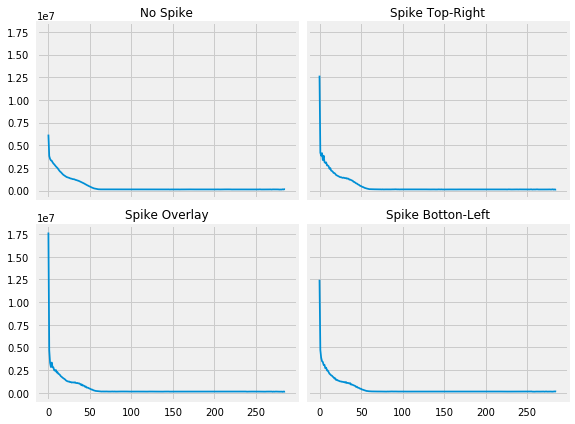

In [298]:
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(8, 6))
titles = ["No Spike", "Spike Top-Right", "Spike Overlay", "Spike Botton-Left"]
for frame, ax, tit in zip(rffts, axes.flatten(), titles):
    prof = radial_profile(frame)
    ax.plot(prof)
    ax.set_title(tit)

plt.tight_layout()

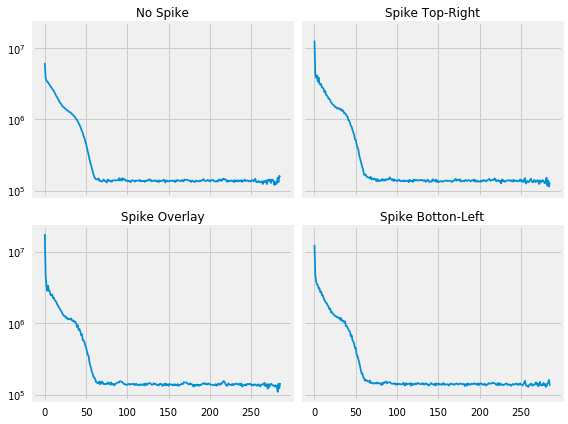

In [299]:
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(8, 6))
titles = ["No Spike", "Spike Top-Right", "Spike Overlay", "Spike Botton-Left"]
for frame, ax, tit in zip(rffts, axes.flatten(), titles):
    prof = radial_profile(frame)
    ax.semilogy(prof)
    ax.set_title(tit)

plt.tight_layout()

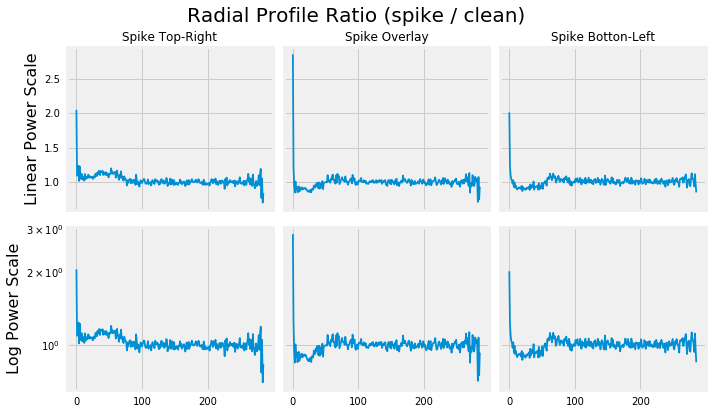

In [313]:
fig, axes = plt.subplots(2, 3, sharex=True, sharey="row", figsize=(10, 6))
titles = ["Spike Top-Right", "Spike Overlay", "Spike Botton-Left"]
for i, frame in enumerate(rffts[1:]):
    ratio = radial_profile(frame) / radial_profile(rffts[0])
    axes[0, i].plot(ratio)
    axes[0, i].set_title(titles[i])
    axes[1, i].semilogy(ratio)


axes[0, 0].set_ylabel("Linear Power Scale", fontsize=16)
axes[1, 0].set_ylabel("Log Power Scale", fontsize=16)
plt.suptitle("Radial Profile Ratio (spike / clean)", fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

In [340]:
spike_mask = np.diff(rffts, axis=0).mean(0)

ds9.display(spike_mask)

## Parallactic Angles

In [35]:
reorganized_list = listing(join(paths.output, "sci_flatted"))
# drop that one blank image
del reorganized_list[87]

# use method from NIRC2_preprocessing.py b/c vip
# version incorrectly parses NIRC2 headers
angles = get_parallactic_angles(reorganized_list)

In [36]:
vip.fits.write_fits(join(paths.output, "sirius-b_pa.fits"), angles)

Fits file successfully saved


## Cropping

Now let's crop the cube to save on space and runtime later. Based on the NIRC2 platescale and the distance to Sirius B, we can crop to the inner ~3AU or so (a little bit more to get a even size).

In [38]:
# crop to inner ~3AU
cube_crop = vip.preproc.cube_crop_frames(centered, 256)

New shape: (205, 256, 256)


In [212]:
ds9.display(cube_crop)

In [39]:
vip.fits.write_fits(join(paths.output, "sirius-b_cube.fits"), cube_crop)

Fits file successfully overwritten
